In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# X_train = train_data.drop("Survived", axis=1)
# Y_train = train_data['Survived']
# X_test = test_data


# Displaying Initial Training Data

In [3]:
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Dislay Number of Null values

In [4]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Displaying Initial Test Data

In [5]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Displaying Number of null value in Test Data

In [6]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
# import the BaseEstimator
from sklearn.base import BaseEstimator

class DropColumns(BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
        print(self.cols)
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        X.drop(self.cols,axis = 1, inplace = True)
        return X
    
#===============================Cabin Columns Feature Engineerong
class CabinTransform(BaseEstimator):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, data):
        cabinValues = [1,2,3,4,5,6,7,8]
        deck = data['Cabin'].dropna(axis = 0).str[0:1].unique()
        cabinKey = np.sort(deck, kind = 'quick')
        self.deckPair = {cabinKey[i]: cabinValues[i] for i in range(len(cabinKey))} 
        data['Cabin'].fillna('0',inplace = True)
        data['Deck'] = data['Cabin'].apply(lambda x : self.setDeck(x))
        data['Deck'] = data['Deck'].astype('int32')
        return data
    
    def setDeck(self,x):
        char1 = x[0:1]
        if char1 == '0':
            return 0
        else:
            return self.deckPair[char1]


    

In [8]:
# ===================================Pipe Line for Age columns============================
class AgeandFareTransform(BaseEstimator):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, data):
        if len(data) == 1:
            data['Fare'].fillna(value = data['Fare'].mean(),axis = 0,inplace = True) ## fillNa with with
            data['Age'].fillna(value = data['Age'].mean(),axis = 0,inplace = True) ## fillNa with with
            data['Age'] = data['Age'].astype('int32')
            return data
        else:    
            nullIndex = data['Age'].index[data['Age'].apply(np.isnan)]
            rand_age = self.getStatistic(data)
            sr1 = pd.Series(rand_age, index = nullIndex) # It is necessary to set indexof NaN to series,so that it can set values according to index
            data['Age'].fillna(value = sr1,axis = 0,inplace = True) ## fillNa with with same length and on same index
            data['Age'] = data['Age'].astype('int32')
            data['Fare'].fillna(value = data['Fare'].mean(),axis = 0,inplace = True) ## fillNa with with same length and on same index
            return data
    
    def getStatistic(self,data):
        mean = data['Age'].mean()
        std = data['Age'].std()
        is_null = data["Age"].isnull().sum()
#         print("Mean:{mean},Std:{std},isNull:{is_null}".format(mean = mean,std = std,is_null = is_null))
        rand_age = np.random.randint(mean - std, mean + std, size = is_null)
        return rand_age
    

class filEmbark(BaseEstimator):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    def transform(self, data):
        data['Embarked'].fillna(value = 'S',axis = 0,inplace = True)
        ports = {"S": 0, "C": 1, "Q": 2}
        data['Embarked'] = data['Embarked'].map(ports)
        return data
    
class Gender(BaseEstimator):
    def __init__(self):
        self.genders = {"male": 0, "female": 1}
        
    def fit(self, X, y=None):
        return self
    def transform(self, data):
        data['Sex'] = data['Sex'].map(self.genders)
        return data
    
class SibspParch(BaseEstimator):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, data):
        data['relatives'] = data['SibSp'] + data['Parch']
        data.loc[data['relatives'] > 0,'not_alone'] = 1
        data.loc[data['relatives'] == 0,'not_alone'] = 0
        return data
    

In [9]:
# Drop columns sequence
#1.['PassengerId','Name'];(no Operation)
#2. Cabin
#. Ticket(No operation)
#SibSp','Parch','not_alone'

In [10]:
non_operatinal_columns = ['PassengerId','Name','Ticket'];
operatinalcolumns = ['Cabin','SibSp','Parch','not_alone'];
## Total column to be droped
drop_columns = non_operatinal_columns + operatinalcolumns

In [11]:
# We are building this pipeline for feature engineering and cleaning data
cleaningDataPipeline = Pipeline([ 
    ('setCabin', CabinTransform()),
    ('setAge', AgeandFareTransform()),
    ('filEmbark', filEmbark()),
     ('Gender', Gender()),
    ('Relatives', SibspParch()),
    ('dropColumns', DropColumns(drop_columns)),
#     ('scaler', StandardScaler()), 
])




['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'not_alone']


# Displaying Cleaned Traing Data after pipeline steps

In [12]:
cleaningDataPipeline.fit_transform(train_data) 
train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Deck,relatives
0,0,3,0,22,7.2500,0,0,1
1,1,1,1,38,71.2833,1,3,1
2,1,3,1,26,7.9250,0,0,0
3,1,1,1,35,53.1000,0,3,1
4,0,3,0,35,8.0500,0,0,0


# Displaying Cleaned Test Data after pipeline steps

In [13]:
cleaningDataPipeline.fit_transform(test_data)
test_data.head()

,Pclass,Sex,Age,Fare,Embarked,Deck,relatives
0,3,0,34,7.8292,2,0,0
1,3,1,47,7.0000,0,0,1
2,2,0,62,9.6875,2,0,0
3,3,0,27,8.6625,0,0,0
4,3,1,22,12.2875,0,0,2


# Check Null values in cleaned Training Data

In [14]:
train_data.isna().sum()

Survived     0
Pclass       0
Sex          0
Age          0
Fare         0
Embarked     0
Deck         0
relatives    0
dtype: int64

# Check Null  values in cleaned Testing Data

In [15]:
test_data.isna().sum()
#X_test[X_test['Fare'].isnull()] Check particular columns

Pclass       0
Sex          0
Age          0
Fare         0
Embarked     0
Deck         0
relatives    0
dtype: int64

In [16]:
# Splitting Traing Data
from sklearn.model_selection import train_test_split,KFold,cross_val_score
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data['Survived']
# X_test = test_data
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size = 0.2, random_state=42)

In [17]:
X_train.shape

(712, 7)

In [18]:
# # Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score



# Evaluate some model and check performance usinf KFold

ScaledLR: 0.797711 (0.067073)
ScaledRMF: 0.785192 (0.041713)
ScaledKNN: 0.799159 (0.044064)
ScaledGausian: 0.789280 (0.058405)
PerceptronNB: 0.630340 (0.111607)
ScaledSVM: 0.813185 (0.060794)
ScaledDT: 0.757101 (0.033770)


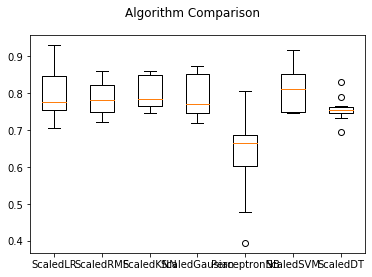

In [19]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
pipelines.append(('ScaledRMF', Pipeline([('Scaler', StandardScaler()),('RMF', RandomForestClassifier(n_estimators=100))])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier(n_neighbors = 3))])))
pipelines.append(('ScaledGausian', Pipeline([('Scaler', StandardScaler()),('Gausian', GaussianNB())])))
pipelines.append(('PerceptronNB', Pipeline([('Scaler', StandardScaler()),('Perceptron', Perceptron(max_iter=5))])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC(gamma='auto',kernel='rbf'))])))
pipelines.append(('ScaledDT', Pipeline([('Scaler', StandardScaler()),('DT', DecisionTreeClassifier())])))

results = []
names=[]
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [20]:
finalMachineModel = Pipeline([ 
    ('scaler', StandardScaler()), 
    ('LR',SVC(gamma='auto',kernel='rbf'))
])

finalMachineModel.fit(X_train,Y_train) 
pred = finalMachineModel.predict(X_val)
print(accuracy_score(Y_val, pred))


0.8156424581005587


In [21]:
test_data22 = pd.read_csv('data/test.csv')
xxtest = test_data22[5:6]
xxtest['Cabin'].fillna(value ='C85',inplace = True,axis = 0)

xxtest

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.225,C85,S


In [26]:
cleaningDataPipeline.fit_transform(xxtest) 
# # machinePipeline
xxtest

,Pclass,Sex,Age,Fare,Embarked,Deck,relatives
5,3,0,14,9.225,0,1,0


In [28]:
pred = finalMachineModel.predict(xxtest)
pred

array([0], dtype=int64)

In [29]:
# # Export finel model
import joblib # 
joblib.dump(cleaningDataPipeline, "clean_data.joblib", compress=True)
joblib.dump(finalMachineModel, "SVM_Model.joblib", compress=True)


['SVM_Model.joblib']

In [31]:
# # Import JOblib
cleanDataPipeline = joblib.load("clean_data.joblib")
SVM_model= joblib.load("SVM_Model.joblib")

In [33]:
xxtest

,Pclass,Sex,Age,Fare,Embarked,Deck,relatives
5,3,0,14,9.225,0,1,0


In [35]:
test_data22 = pd.read_csv('data/test.csv')
singl = test_data22[5:6]
singl['Cabin'].fillna(value ='C85',inplace = True,axis = 0)

singl

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.225,C85,S


In [36]:
cleanDataPipeline.fit_transform(singl) 
# # machinePipeline
singl

,Pclass,Sex,Age,Fare,Embarked,Deck,relatives
5,3,0,14,9.225,0,1,0


In [37]:
pred = SVM_model.predict(singl)
pred

array([0], dtype=int64)

In [42]:
train_data22 = pd.read_csv('data/train.csv')

test2 = train_data22[2:3]
test2['Cabin'].fillna(value ='C85',inplace = True,axis = 0)

test2 = test2.drop("Survived", axis=1)
test2

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,C85,S


In [43]:
cleanDataPipeline.fit_transform(test2) 
# # machinePipeline
test2

,Pclass,Sex,Age,Fare,Embarked,Deck,relatives
2,3,1,26,7.925,0,1,0


In [44]:
pred = SVM_model.predict(test2)
pred

array([1], dtype=int64)